# Mask R-CNN

In [1]:
%matplotlib inline

In [65]:
import os
import sys
import glob
import random
import math
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
from skimage.morphology import label  #Used for Run-Length-Encoding RLE to create final submission

import matplotlib
import matplotlib.pyplot as plt

from MaskRCNN.config import Config
import MaskRCNN.utils as utils
import MaskRCNN.model as modellib
import MaskRCNN.visualize as visualize
from MaskRCNN.model import log

In [40]:
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save submission outputs 
OUTPUT_DIR = os.path.join(ROOT_DIR, "outputs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("Download the COCO trained weights")
    # utils.download_trained_weights(COCO_MODEL_PATH)
    

In [4]:
train_path = os.path.join(ROOT_DIR, 'input/stage1_train')
val_path = os.path.join(ROOT_DIR,'input/stage1_val')
test_path = os.path.join(ROOT_DIR, 'input/stage1_test')   #path to test data file/folder

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
#     USE_MINI_MASK = False
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING        

In [6]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING        

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [8]:
def display_masks(image, mask, class_names):
    """Display the given image and the masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    
#     to_display.append(mask)
    
    # Pull masks of instances belonging to the same class.
    m = mask
    m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
    to_display.append(m)
    titles.append("H x W={}x{} - {}".format(image.shape[0], image.shape[1], class_names[0]))
    visualize.display_images(to_display, titles=titles, cols=2, cmap="Blues_r")

In [9]:
class NucleiDataset(utils.Dataset):
    """Loads the nuclei dataset.
    """
    
    def load_nuclei(self, path):
        '''
        Loads images from path/{id}/images/{id}.png
        '''
        self.add_class("nuclei", 1, "nuclei")
        self.path = path
        
        img_info = [(id, '{0}/{1}/images/{1}.png'.format(path, id)) for id in os.listdir(path)]
        for id, path in img_info:
            data = plt.imread(path)[:, :, 0]
            height, width = data.shape
            
            self.add_image('nuclei', id, path, width=width, height=height)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, 0:3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id, width=256, height=256):
        '''
        Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array. 
        Generate instance masks for shapes of the given image ID.
        '''
        info = self.image_info[image_id]
        
        img_paths = glob.glob('{0}/{1}/masks/*.png'.format(self.path, info['id']))
        num_labels = len(img_paths)
        

#         masks = skimage.io.imread_collection(img_paths).concatenate()  #masks.shape = (num_masks, img_height, img_width)
#         mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
#         plt.imshow(mask)
#         mask = skimage.transform.resize(mask, output_shape=mask.shape+(num_labels,), mode='constant', preserve_range=True)
#         Y_data = np.array(mask, dtype=np.bool)
        width = info['width']
        height = info['height']
        mask = np.zeros([height,
                         width,
                         num_labels],
                        dtype=np.bool)
        num_labels = 0
        for i, mask_file in enumerate(img_paths):
#             subpath = os.path.join(root_path, 'masks', mask_file)
            data = plt.imread(mask_file)[:, :]
        
            if np.sum(data) != 0:
                data = (data != 0)
                mask[:, :, num_labels] = data
                num_labels += 1
        
        class_ids = np.array([1] * num_labels)
        class_ids = class_ids.astype(np.int32)
        
        self.image_info[image_id]['mask_shape'] = mask.shape
        
        return mask, class_ids

In [10]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(train_path)
dataset_train.prepare()

(256, 320, 3)
(256, 320, 33)


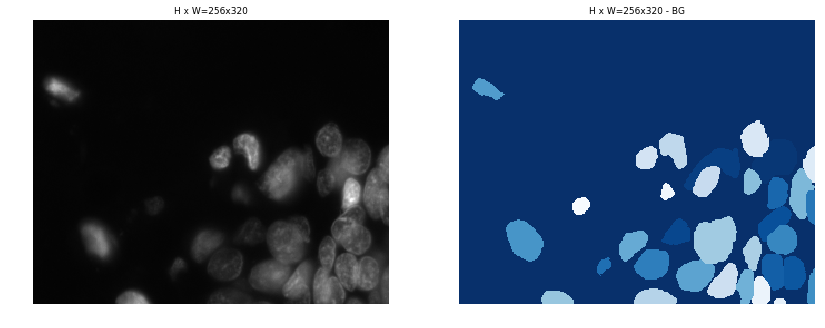

(256, 256, 3)
(256, 256, 15)


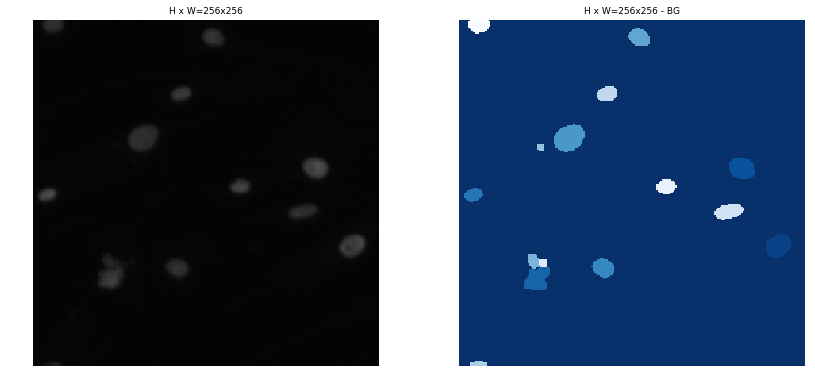

(256, 320, 3)
(256, 320, 11)


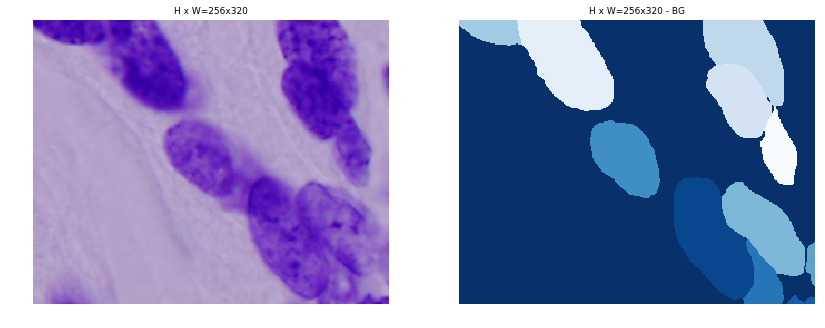

(256, 256, 3)
(256, 256, 10)


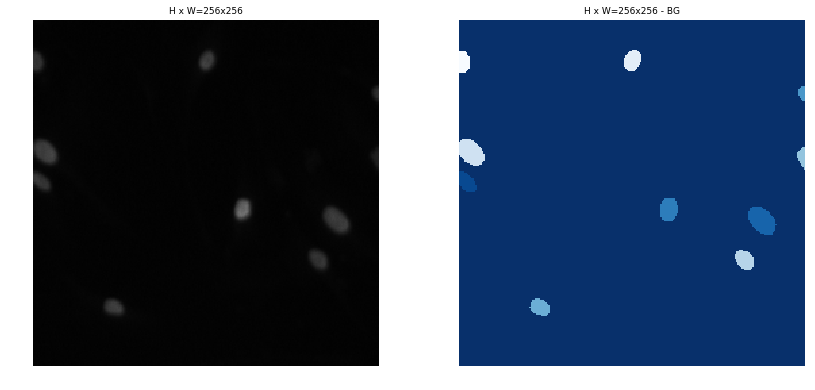

In [11]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)[:, :, 0:3]
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    print(mask.shape)
    display_masks(image, mask, dataset_train.class_names)

In [12]:
# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(val_path)
dataset_val.prepare()

In [13]:
print(dataset_train.image_ids[2])
print(dataset_train.image_info[0]['id'])

2
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


In [14]:
print(dataset_val.image_ids[2])
print(dataset_val.image_info[0]['id'])

2
05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13


## Create Model

In [26]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [27]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training

In [28]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180310T0837\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


100/100 [==============================] - 359s 4s/step - loss: 1.8373 - rpn_class_loss: 0.2205 - rpn_bbox_loss: 0.6574 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3380 - val_loss: 1.4680 - val_rpn_class_loss: 0.0886 - val_rpn_bbox_loss: 0.4812 - val_mrcnn_class_loss: 0.3167 - val_mrcnn_bbox_loss: 0.2850 - val_mrcnn_mask_loss: 0.2965


In [29]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_nuclei_head_ep_100.h5")
model.keras_model.save_weights(model_path)

## Detection

In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180310T0837\mask_rcnn_nuclei_0001.h5


C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (512, 512, 3)         min:    0.00000  max:   53.00000
image_meta               shape: (10,)                 min:    0.00000  max:  696.00000
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (5, 4)                min:   50.00000  max:  512.00000
gt_mask                  shape: (512, 512, 5)         min:    0.00000  max:    1.00000


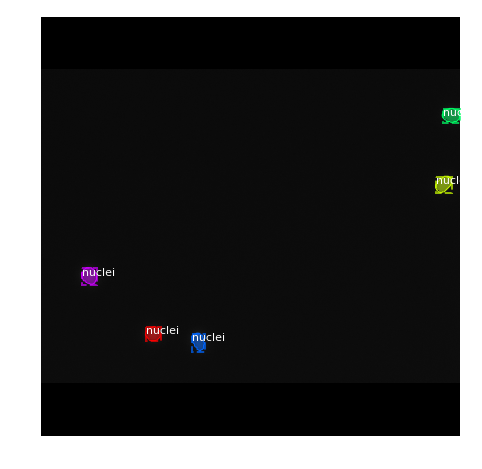

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:   53.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  -50.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


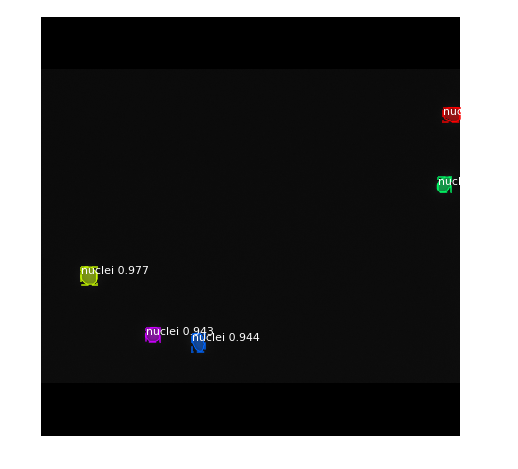

In [17]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [18]:
r['rois']

array([[304,  49, 326,  68],
       [110, 492, 127, 512],
       [195, 485, 213, 501],
       [386, 185, 408, 200],
       [379, 128, 396, 145]])

## Make Predictions

In [19]:
# Test dataset
dataset_test = NucleiDataset()
dataset_test.load_nuclei(test_path)
dataset_test.prepare()

In [20]:
print(dataset_test.image_ids[2])
print(dataset_test.image_info[0]['id'])

2
0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


In [61]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [21]:
results = dict()
for image_id in dataset_test.image_ids:
    info = dataset_test.image_info[image_id]
    image = dataset_test.load_image(image_id)
    results[info['id']] = model.detect([image], verbose=0)

In [105]:
img_id = 0
r = results[dataset_test.image_info[img_id]['id']][0]
print(dataset_test.load_image(image_id).shape)
print(r['masks'].shape)

(256, 256, 3)
(256, 256, 6)


In [136]:
Y_hat_upsampled = []
for id_ in dataset_test.image_ids[:10]:
    mask = results[dataset_test.image_info[id_]['id']][0]['masks']
    image = dataset_train.load_image(id_)
    img_upscaled = skimage.transform.resize(mask, (image.shape[0], image.shape[1]), mode='constant', preserve_range=True)
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
    print(img_upscaled.shape)
len(Y_hat_upsampled)

(256, 256, 6)
(256, 256, 45)
(256, 320, 30)
(256, 320, 6)
(256, 320, 7)
(256, 256, 28)
(256, 256, 17)
(360, 360, 16)
(256, 256, 5)
(360, 360, 8)


10

In [131]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for id_ in dataset_test.image_ids:
    rle = list(prob_to_rles(Y_hat_upsampled[id_]))
    rles.extend(rle)
    new_test_ids.extend([dataset_test.image_info[id_]['id']] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

1965

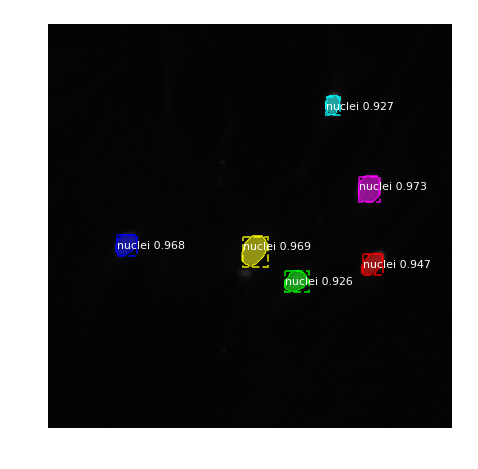

In [132]:
r = results[dataset_test.image_info[0]['id']][0]
original_image = dataset_test.load_image(0)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [133]:
# Create submission DataFrame
sub = pd.DataFrame()

# img_ids = []
# rois = []
# for img_id, data in results.items():
#     img_ids.append(img_id)
#     r = results[img_id][0]['rois']
#     rois.append(' '.join(str(y) for y in r.flatten()))

# sub['ImageId'] = img_ids
# sub['EncodedPixels'] = rois

sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,307250 5 307503 10 307758 12 308014 12 308270 ...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50534 9 50788 12 51043 14 51298 15 51553 16 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,142219 6 142473 10 142728 11 142983 12 143238 ...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,97169 6 97422 10 97675 14 97930 15 98185 17 98...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,247705 6 247959 8 248214 9 248469 10 248723 12...


In [134]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv(OUTPUT_DIR + "\sub-{}.csv".format(timestamp), index=False)

Submission output to: sub-20180310-1134.csv


## Evaluation

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))